In [72]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [-0.5]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [73]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
# Tau_global = 1e-100   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

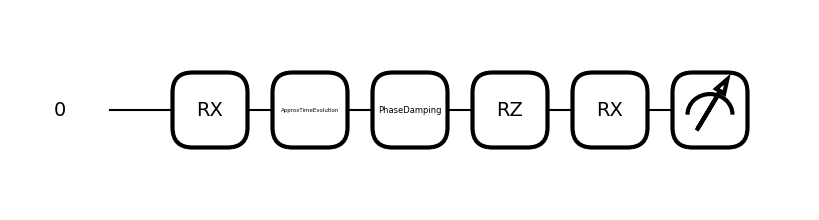

In [74]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras[0], paras[1]

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [75]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [76]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 2 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'L-BFGS-B', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

In [77]:
a = np.zeros(5)
b = np.array([1,2,3,4,5])

a[:] = b[:]

a

tensor([1., 2., 3., 4., 5.], requires_grad=True)

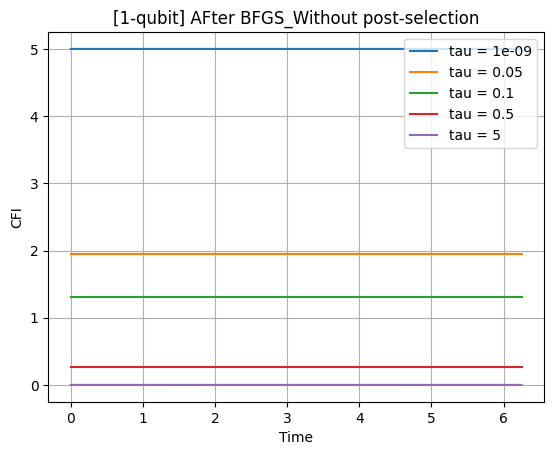

In [78]:
tau_plot = 1e-09, 5e-2, 1e-1, 5e-1, 5
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, 5e-2])

Sweep_data_arange = np_.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for i in range(len(tau_plot)):
    Tau_global = tau_plot[i]
    
    Paras_init = np.zeros(2)
    Paras_init[:2] = np.pi/2

    Gamma_ps_preset = 0.8
    Set_Iterations = 1

    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[i][:, 0] = Optimized_Result[1][:,2]
    Para_store[i][:, 1] = Optimized_Result[1][:,3]
    
    # plt.plot(Sweep_data_arange, Optimized_Result[0][:, 1], label = f'Before_tau = {tau_plot[i]}')
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, 1], label = f'tau = {tau_plot[i]}')
    plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
    
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

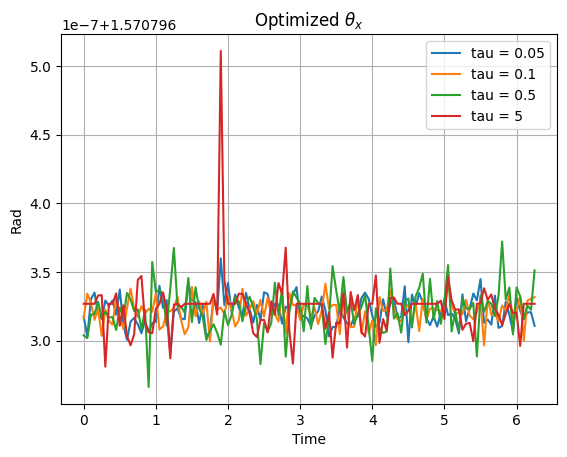

In [79]:
for i in range(1, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'tau = {tau_plot[i]}')
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

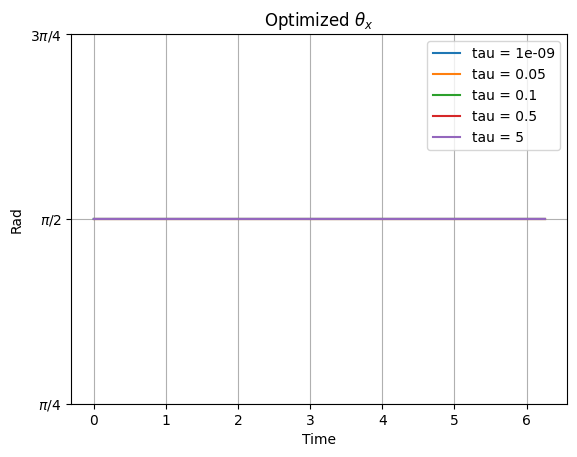

In [80]:
for i in range(0, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 0], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()


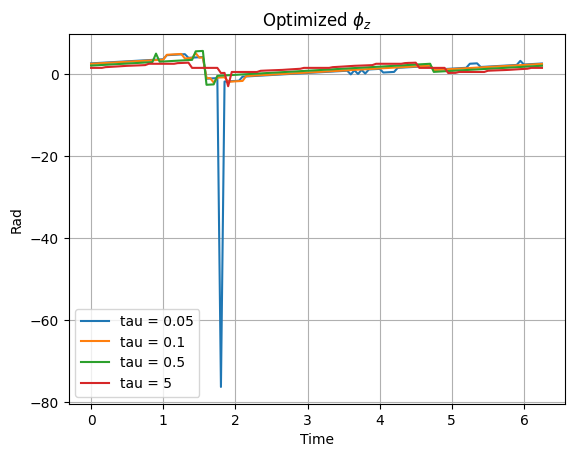

In [81]:
for i in range(1, len(tau_plot)):
    plt.plot(Sweep_data_arange, Para_store[i][:, 1], label = f'tau = {tau_plot[i]}')
plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

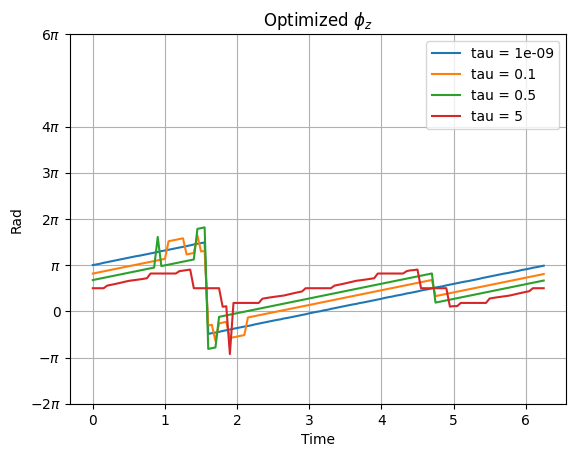

In [86]:
for i in range(0, len(tau_plot)):
    if i != 1:
        plt.plot(Sweep_data_arange, Para_store[i][:, 1], label = f'tau = {tau_plot[i]}')

# Set the yticks to be at -2π, -π, 0, π, 2π, 3π, 4π, and 6π
plt.yticks(
    [-2*np.pi, -np.pi, 0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 6*np.pi], 
    ['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$', '$6\pi$']
)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()


In [83]:
Para_store[0][:,0]

tensor([1.57079641, 1.57079603, 1.57079626, 1.57079672, 1.57079631,
        1.57079628, 1.5707963 , 1.57079616, 1.57079616, 1.5707959 ,
        1.57079625, 1.5707955 , 1.57079631, 1.57079631, 1.57079632,
        1.57079664, 1.57079633, 1.5707963 , 1.57079603, 1.57079739,
        1.57079638, 1.57079614, 1.57079643, 1.57079637, 1.57079652,
        1.5707964 , 1.57079633, 1.57079664, 1.57079589, 1.57079631,
        1.57079641, 1.57079646, 1.57079628, 1.57079631, 1.57079636,
        1.57079635, 1.57079636, 1.5707964 , 1.57079571, 1.57079655,
        1.57079631, 1.57079604, 1.57079638, 1.57079631, 1.57079643,
        1.57079647, 1.57079646, 1.57079655, 1.57079646, 1.57079677,
        1.57079628, 1.57079632, 1.5707963 , 1.57079632, 1.57079629,
        1.5707963 , 1.57079637, 1.57079626, 1.5707963 , 1.57079632,
        1.57079632, 1.57079634, 1.57079642, 1.57079655, 1.57079637,
        1.57079633, 1.57079612, 1.57079643, 1.57079633, 1.57079632,
        1.57079635, 1.57079644, 1.57079645, 1.57

In [84]:
Para_store[0][:,1]

tensor([ 3.14732128e+00,  3.18606084e+00,  3.23606899e+00,
         3.29730827e+00,  3.34732187e+00,  3.39731918e+00,
         3.44732123e+00,  3.49731407e+00,  3.54734445e+00,
         3.59729881e+00,  3.64732314e+00,  3.69730926e+00,
         3.74731610e+00,  3.78602612e+00,  3.83604184e+00,
         3.88608313e+00,  3.93612225e+00,  3.98609109e+00,
         4.03605996e+00,  4.09734910e+00,  4.13606614e+00,
         4.18607373e+00,  4.23606474e+00,  4.28607359e+00,
         4.33606878e+00,  4.38605564e+00,  4.43604104e+00,
         4.48605273e+00,  4.54736452e+00,  4.59731498e+00,
         4.63605994e+00,  4.68611541e+00, -1.53587402e+00,
        -1.48584049e+00, -1.44715656e+00, -1.39708328e+00,
        -1.33586850e+00, -1.28587271e+00, -1.23582706e+00,
        -1.18591940e+00, -1.13587058e+00, -1.08589564e+00,
        -1.03588491e+00, -9.97013937e-01, -9.47068681e-01,
        -8.85794711e-01, -8.35844329e-01, -7.85889718e-01,
        -7.35859656e-01, -6.85864879e-01, -6.35885408e-0

In [85]:
Optimized_Result

array([[[1.00000000e-04, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00],
        [5.01000000e-02, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00],
        [1.00100000e-01, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00],
        ...,
        [6.15010000e+00, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00],
        [6.20010000e+00, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00],
        [6.25010000e+00, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00]],

       [[1.00000000e-04, 2.52221603e-05, 1.57079633e+00, 1.57079633e+00],
        [5.01000000e-02, 2.51476157e-05, 1.57079633e+00, 1.57079633e+00],
        [1.00100000e-01, 2.49479080e-05, 1.57079633e+00, 1.57079633e+00],
        ...,
        [6.15010000e+00, 2.48076710e-05, 1.57079633e+00, 1.57079633e+00],
        [6.20010000e+00, 2.50671643e-05, 1.57079633e+00, 1.57079633e+00],
        [6.25010000e+00, 2.52020744e-05, 1.57079633e+00, 1.57079633e+00]]])